In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
# Computational modules
import dask
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import cartopy.crs as ccrs
import datetime
# Maps   
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray
import geopandas as gpd
from shapely.geometry import box, mapping
import dateutil
import pysolar
from cartopy.util import add_cyclic_point
#!{sys.executable} -m pip install --user cmip6_preprocessing

#!{sys.executable} -m pip install --user import_ipynb
import import_ipynb

# Local files and utility functions
sys.path.append("./subroutines/")
import pices
#!{sys.executable} -m pip install --user pytz
#!{sys.executable} -m pip install --user tables
import tables
import pytz
#from tzwhere import tzwhere
#!{sys.executable} -m pip install --user pvlib
import pvlib

# Import other notebooks
import albedo
import regrid_cmip6

import xesmf as xe
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

get_ipython().run_line_magic("matplotlib", "inline")
plt.rcParams["figure.figsize"] = 12, 6
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")

importing Jupyter notebook from albedo.ipynb
importing Jupyter notebook from regrid_cmip6.ipynb


In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34447 Dashboard: /user/trondkr/proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 63.33 GB


In [3]:
class Config_pices():
    df = pd.read_csv("https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv")
    fs = gcsfs.GCSFileSystem(token="anon", access="read_only")
    grid_labels = ["gn"]  # Can be gr=grid rotated, or gn=grid native
    member_ids = ["r1i1p1f1"]  #
    experiment_ids = ["ssp585"]  #'abrupt-4xCO2',
    source_ids = ["CanESM5"]
    variable_ids = ["uas","vas","tos","clt"]
    table_ids = ["Amon","Amon","Omon","Amon"]  # Amon=atmospheric variables, Omon=Ocean variables, SImon=sea-ice variables
    dset_dict = {}
    start_date="1950-01-01"
    end_date="2100-08-01"
    clim_start="1961-01-01"
    clim_end="1990-01-01"
    selected_depth=0
  
# Create the object
config_pices_obj = Config_pices()
config_pices_obj = pices.get_and_organize_cmip6_data(config_pices_obj)

Running historical query on data: 
 ==> source_id=='CanESM5'and table_id=='Amon' and grid_label=='gn' and experiment_id=='historical' and variable_id=='uas'

Running projections query on data: 
 ==> source_id=='CanESM5'and table_id=='Amon' and member_id=='r1i1p1f1' and grid_label=='gn' and experiment_id=='ssp585' and variable_id=='uas'

CanESM5 => Dates extracted range from 1950-01-16 12:00:00 to 2100-07-16 12:00:00

Running historical query on data: 
 ==> source_id=='CanESM5'and table_id=='Amon' and grid_label=='gn' and experiment_id=='historical' and variable_id=='vas'

Running projections query on data: 
 ==> source_id=='CanESM5'and table_id=='Amon' and member_id=='r1i1p1f1' and grid_label=='gn' and experiment_id=='ssp585' and variable_id=='vas'

CanESM5 => Dates extracted range from 1950-01-16 12:00:00 to 2100-07-16 12:00:00

Running historical query on data: 
 ==> source_id=='CanESM5'and table_id=='Omon' and grid_label=='gn' and experiment_id=='historical' and variable_id=='tos'



In [4]:
# Following Roland Seferian, equation 3
# https://www.geosci-model-dev.net/11/321/2018/gmd-11-321-2018.pdf

def calculate_alpha_dir(n_lambda,µ):
    a = np.sqrt(1.0 - (1.0 - µ**2)/n_lambda**2)
    b = ((a-n_lambda*µ)/(a+n_lambda*µ))**2    
    c = ((µ-n_lambda*a)/(µ+n_lambda*a))**2

    return 0.5*(b+c)

In [5]:
def calculate_diffuse_reflection(n_λ,σ):
    # Diffuse albedo from Jin et al., 2006 (Eq 5b) 
    return -0.1479 + 0.1502*n_λ-0.0176*n_λ*σ

In [6]:
def surface_roughness(µ, σ):
    # Surface roughness following Jin et al. 2014 equation 4
    # This rougness parameter determines the Fresnel refraction 
    # index from flat surface
    return (0.0152-1.7873*µ + 6.8972*(µ**2)-8.5778*(µ**3)+ 4.071*σ-7.6446*µ*σ) * np.exp(0.1643-7.8409*µ-3.5639*µ**2-2.3588*σ+10.054*µ*σ)

In [7]:
def calculate_direct_reflection(n_λ,µ,σ):
    # Direct reflection following Jin et al. 2014 equation 1
    f_0 = calculate_alpha_dir(1.34,µ)
    f_λ = calculate_alpha_dir(n_λ,µ)
    
    return f_λ-(surface_roughness(µ, σ)*f_λ/f_0)

In [8]:
def calculate_direct_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, µ, alpha_direct):
   
    rw=0.48168549-0.014894708*σ-0.20703885*σ**2
 
    # Determine absorption and backscattering
    # coefficients to determine reflectance below the surface (Ro) once for all
    # Backscattering by chlorophyll:
    a_bp = 0.06*alpha_chl*np.exp(np.log(chl)*0.65) + 0.2*(0.00635+0.06*(np.exp(np.log(chl)*0.65))*np.exp(0.014*(440.0-λ)))
   
    # Backscattering of biological pigment (b_chl) with λ expressed here in nm and [Chl] in mg m−3. This
    # formulation is valid for [Chl] ranging between 0.02 and 2 mg m−3 (Morel and Maritorena (2001))
    # Equation 12 Roland Seferian, 2018
    b_chl=(0.416*np.exp(0.766*np.log(chl)))*(0.002+0.01*(0.5-0.25*np.log(chl))*np.exp((0.5*(np.log(chl)-0.3))*np.log(λ/550.0)))
                                                                                 
    # # Use Morel 91 formula to compute the direct reflectance below the surface (Morel-Gentili(1991), Eq (12))
    n=0.5*beta_w/(0.5*beta_w + b_chl)
   
    # Equation 11 Roland Seferian, 2018
    beta = 0.6279-0.2227*n-0.0513*n**2 +(0.2465*n - 0.3119)*µ
    
    # Equation 10 Roland Seferian, 2018
    R0 = beta * (0.5*beta_w + b_chl)/(alpha_w + a_bp)
   
    # Water leaving albedo, equation 8 Roland Seferian, 2018
    return (R0*(1.0-rw)/(1-rw*R0)) 

In [9]:
def calculate_diffuse_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, alpha_direct):
    #  In the case of ocean interior reflectance for direct incoming radiation it depends on µ = cos(θ) whereas in the
    # case of ocean interior reflectance for diffuse µ = 0.676. This value is considered an effective angle of incoming radiation of 47.47◦
    # according to Morel and Gentili (1991). Hence
    return calculate_direct_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, np.arccos(0.676), alpha_direct)

In [10]:
def whitecap(wind):
    # Whitecap effect as defined by Salisbury et al. 2014. NOTE that the value in paper is in percent
    # so we use the ratio instead (/100.) 
    # Salisbury, D. J., Anguelova, M. D., and Brooks, I. M.: Global Distribution and Seasonal 
    # Dependence of Satellite-based Whitecap Fraction
    #
    # Whitecaps are the surface manifestation of bubble plumes, created when 
    # surface gravity waves break and entrain air into the water column. 
    # They enhance air-sea exchange, introducing physical processes different from 
    # those operating at the bubble-free water surface. 
  
    return 0.000397*(np.exp(1.59*np.log(wind)))

In [11]:
def calculate_spectral_and_broadband_OSA(wind,alpha_wc,alpha_direct,alpha_diffuse,alpha_direct_chl,alpha_diffuse_chl,solar_energy):
    wc = whitecap(wind)
    OSA=np.zeros((1,2))
    OSA_direct = (alpha_direct + alpha_direct_chl) * (1-wc) + wc*alpha_wc
    OSA_diffuse = (alpha_diffuse + alpha_diffuse_chl) * (1-wc) + wc*alpha_wc
    
    # Integrate across all wavelengths 200-4000nm at 10 nm wavelength bands and then weight by the solar energy at each band.
    # The solar energy is dimensionless with sum equal to 1 and therefore already weighted.
    OSA_direct_broadband = np.sum(OSA_direct*solar_energy,axis=0)
    OSA_diffuse_broadband = np.sum(OSA_diffuse*solar_energy,axis=0)
    
    OSA[0,0]=OSA_direct_broadband
    OSA[0,1]=OSA_diffuse_broadband
    return OSA

In [12]:
def calculate_OSA(µ, uv, chl, wavelengths, refractive_indexes, alpha_chl, alpha_w, beta_w, alpha_wc, solar_energy):
    
    # Solar zenith angle
    # wind is wind at 10 m height (m/s)
    σ = np.sqrt(0.003+0.00512*uv)
         
    # Vectorize the functions
    vec_calculate_direct_reflection=np.vectorize(calculate_direct_reflection)
    vec_calculate_diffuse_reflection=np.vectorize(calculate_diffuse_reflection)
    vec_calculate_direct_reflection_from_chl=np.vectorize(calculate_direct_reflection_from_chl)
    vec_calculate_diffuse_reflection_from_chl=np.vectorize(calculate_diffuse_reflection_from_chl)
    
    # Direct reflection
    alpha_direct = vec_calculate_direct_reflection(refractive_indexes,µ,σ)
   
    # Diffuse reflection
    alpha_diffuse = vec_calculate_diffuse_reflection(refractive_indexes,σ)

    # Reflection from chlorophyll and biological pigments
    alpha_direct_chl = vec_calculate_direct_reflection_from_chl(wavelengths, chl, alpha_chl, alpha_w, beta_w, σ, µ, alpha_direct)
   
    # Diffuse reflection interior of water from chlorophyll
    alpha_diffuse_chl = vec_calculate_diffuse_reflection_from_chl(wavelengths, chl, alpha_chl, alpha_w, beta_w, σ, alpha_direct)

    # OSA
    return calculate_spectral_and_broadband_OSA(uv,alpha_wc,alpha_direct,alpha_diffuse,alpha_direct_chl,alpha_diffuse_chl,solar_energy)

In [13]:
def setup_parameters():
    df=pd.read_csv("data/Wavelength/Fresnels_refraction.csv", header=0, sep=";", decimal=",")
    wavelengths=df["λ"].values
    refractive_indexes=df["n(λ)"].values
    alpha_chl=df["a_chl(λ)"].values
    alpha_w=df["a_w(λ)"].values
    beta_w=df["b_w(λ)"].values
    alpha_wc=df["a_wc(λ)"].values
    solar_energy=df["E(λ)"].values
    print(df.head())
    return wavelengths, refractive_indexes, alpha_chl, alpha_w, beta_w, alpha_wc, solar_energy

### Radiation calculations
To calculate the irradiance at any given location on the planet at the exact same time of day we use the excellent [pvlib](https://github.com/pvlib/pvlib-python) Python library. This library allows us to calculate the direct and diffuse irradiance at the surface. The diffuse and direct (beam) irradiance are both corrected for cloud cover by applying the Liu Jordan equation. The approach is to sequentially calculate the following for each latitude in our grid, but for a fixed longitude position (lon=0) assuming that the solar daily cycle only varies with latitutde and time of day. The cloud cover is accounted for by first calculating the clear sky radiation and then scaling for cloud cover using the Liu Jordan equation.

In [14]:
def radiation(cloud_covers,latitude,month,hour_of_day):
    results=np.zeros((np.shape(cloud_covers)[0],3))
    #lon_180 = np.where(longitude > 180, longitude-360, longitude)
    offset=0 #int(lon_180/15.)
    when =[datetime.datetime(2006,month,15,hour_of_day,0,0,tzinfo=datetime.timezone(datetime.timedelta(hours=offset)))]
    time = pd.DatetimeIndex(when)
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

    module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
    inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
    system = {'module': module, 'inverter': inverter,
                  'surface_azimuth': 180}
    altitude=0.0
    system['surface_tilt'] = latitude
        
    
    # Some calculations are done only on greenwhich meridian line as they are identical around the globe 
    # at the same latitude. For that reason longitude is set to greenwhich meridian and do not change. The only reason 
    # to use longitude would be to have the local sun position for given time but since we calculate position at the same
    # time of the day (hour_of_day) and month (month) we can assume its the same across all longitudes,
    # and only change with latitude.
    
    longitude=0.0
    solpos = pvlib.solarposition.get_solarposition(time, latitude, longitude)

    dni_extra = pvlib.irradiance.get_extra_radiation(time)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    tl = pvlib.clearsky.lookup_linke_turbidity(time,latitude,longitude)

    for cloud_index,cloud_cover in enumerate(cloud_covers):
        
        # cloud cover in percentage units here
        transmittance = ((100.0 - cloud_cover) / 100.0) * 0.75
        # irrads is a DataFrame containing ghi, dni, dhi
        irrads = pvlib.irradiance.liujordan(solpos['apparent_zenith'], transmittance, am_abs)

        aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'],
                                   solpos['apparent_zenith'], solpos['azimuth'])

        total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'],
                                                            system['surface_azimuth'],
                                                            solpos['apparent_zenith'],
                                                            solpos['azimuth'],
                                                            irrads['dni'], irrads['ghi'], irrads['dhi'],
                                                            dni_extra=dni_extra,
                                                            model='haydavies')


       # effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
       #    total_irrad['poa_direct'], total_irrad['poa_diffuse'],
       #    am_abs, aoi, module)
       # print("({},{}) total {} direct: {} diffuse: {}".format(latitude,longitude,total_irrad['poa_direct'][0]+total_irrad['poa_diffuse'][0],
       #                                                total_irrad['poa_direct'][0], 
       #                                                total_irrad['poa_diffuse'][0]))
       
        results[cloud_index,0]=total_irrad['poa_direct']
        results[cloud_index,1]=total_irrad['poa_diffuse']
        results[cloud_index,2]=solpos['zenith']
       
    return results

In [30]:
def create_plot(indata,lon,lat,name,nlevels=None):
    # Make data cyclic around dateline
    lon = np.where(lon > 180, lon-360, lon)
    indata, lon = add_cyclic_point(indata, coord=lon[0,:])
    land_110m = cfeature.NaturalEarthFeature('physical', 'land', '110m')
    proj=ccrs.Robinson()
    ax = plt.axes(projection=proj)
    
    lons,lats=np.meshgrid(lon,lat[:,0])
    print(lons)
    
    if nlevels is None:
        cs=ax.contourf(lons,lats,indata,transform=ccrs.PlateCarree(central_longitude=0.0))
    else:
        cs=ax.contourf(lons,lats,indata,nlevels,transform=ccrs.PlateCarree(central_longitude=0.0))
    plt.title("{}".format(name))
    ax.add_feature(land_110m, color="lightgrey")
    ax.add_feature(cfeature.COASTLINE, edgecolor="black")
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_global()
    plt.colorbar(cs,shrink=0.5)
    plt.show()

       λ      E(λ)  n(λ)  a_chl(λ)  a_w(λ)  b_w(λ)  a_wc(λ)
0  200.0  0.000054  1.45     0.775   3.070  0.1510      0.0
1  210.0  0.000206  1.44     0.752   1.990  0.1190      0.0
2  220.0  0.000349  1.42     0.730   1.310  0.0995      0.0
3  230.0  0.000384  1.41     0.708   0.928  0.0820      0.0
4  240.0  0.000292  1.40     0.685   0.718  0.0685      0.0
=> model: uas_ssp585_gn_CanESM5_r1i1p1f1 variable name: uas
=> model: vas_ssp585_gn_CanESM5_r1i1p1f1 variable name: vas
Reuse existing file: bilinear_128x64_45x90.nc
Reuse existing file: bilinear_128x64_45x90.nc
Reuse existing file: bilinear_291x360_45x90.nc
Reuse existing file: bilinear_128x64_45x90.nc


/opt/conda/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "
/opt/conda/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "
/opt/conda/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


[[-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 ...
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]]


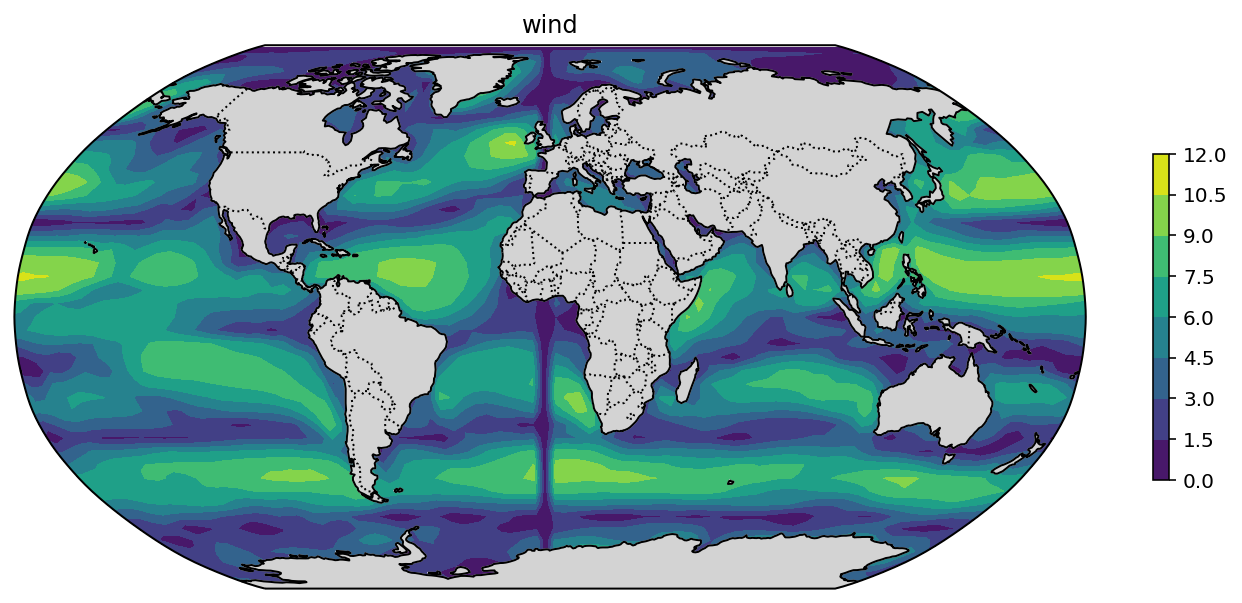

[[-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 ...
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]]


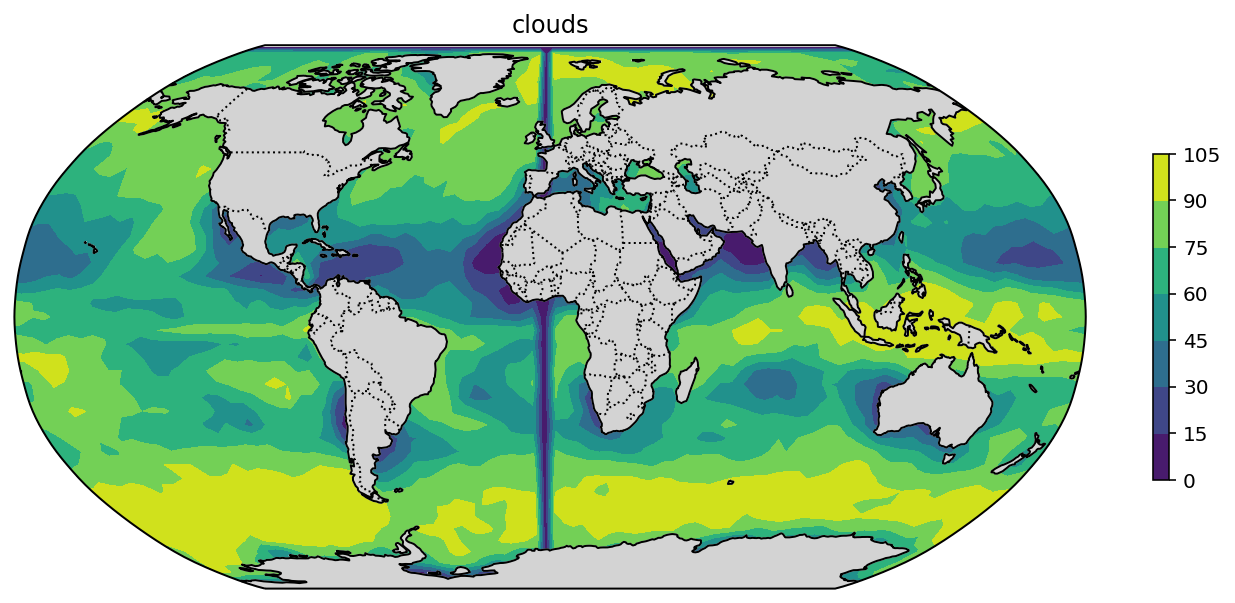

Running for hour 11
[[-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 ...
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]]


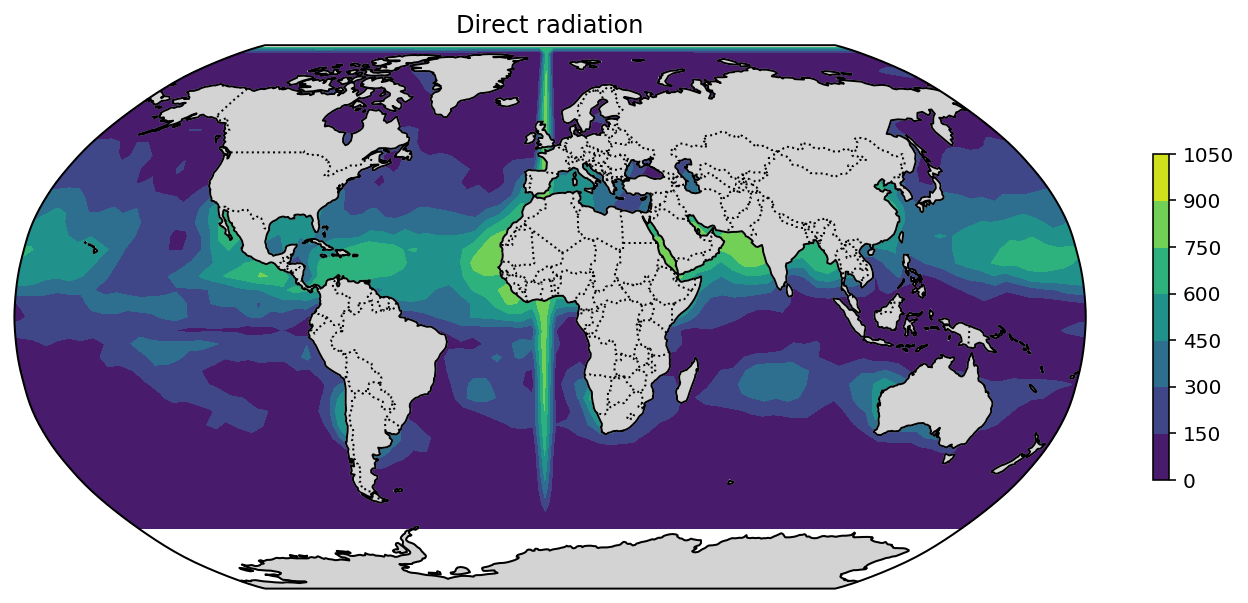

[[-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 ...
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]]


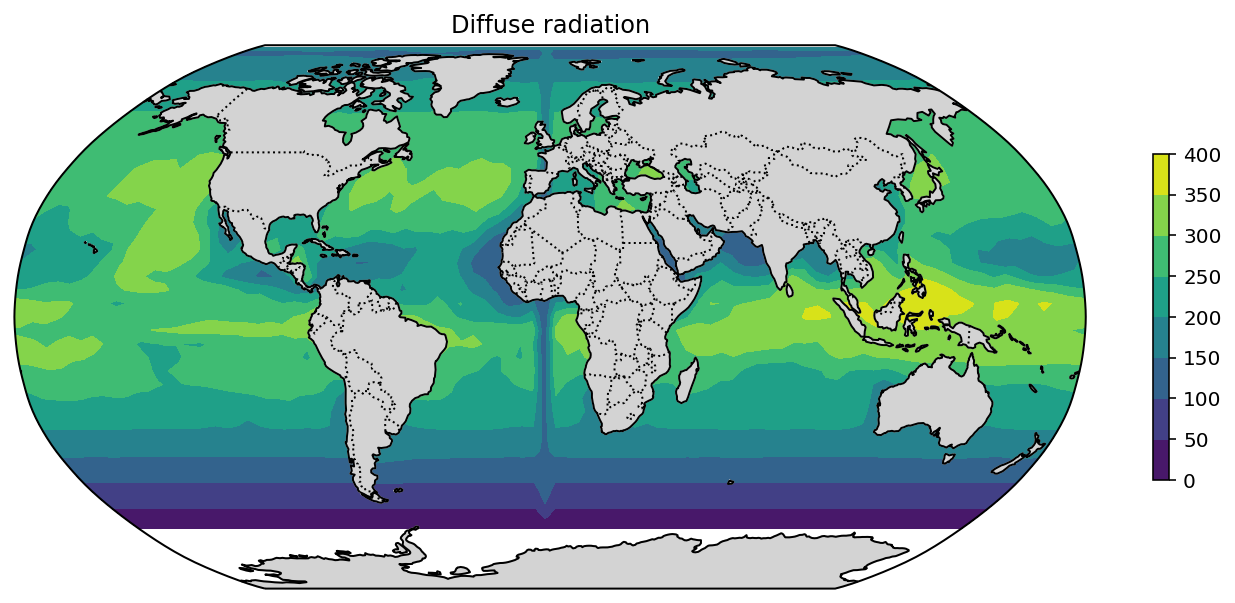

[[-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 ...
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]]


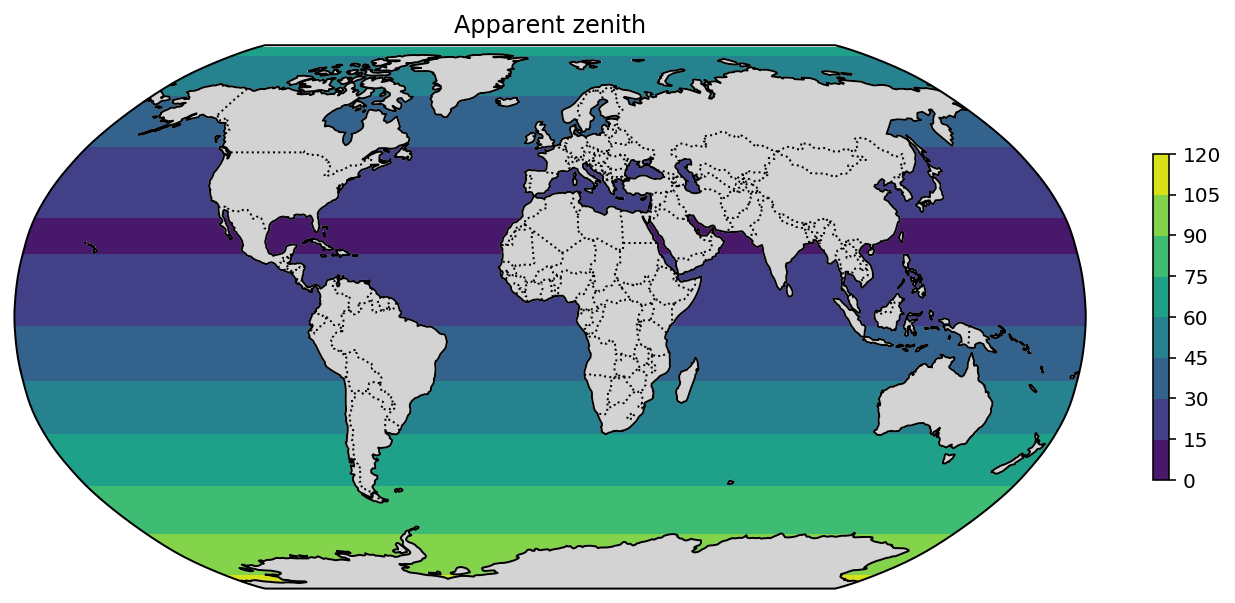

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


[[-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 ...
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]]


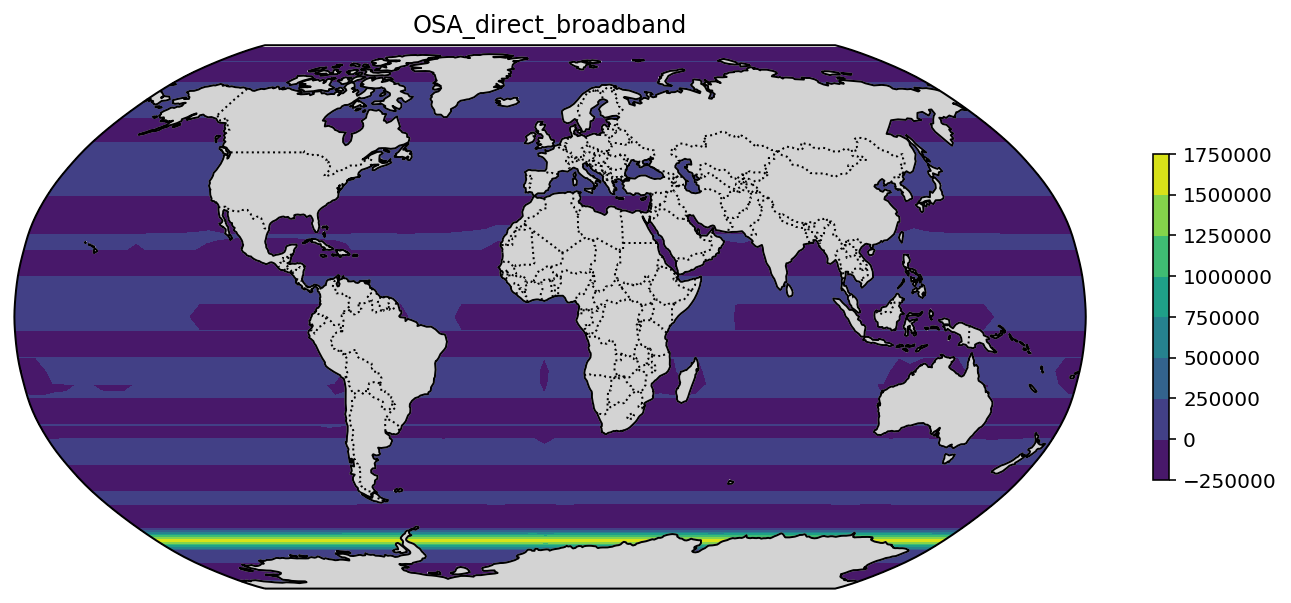

[[-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 ...
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]]


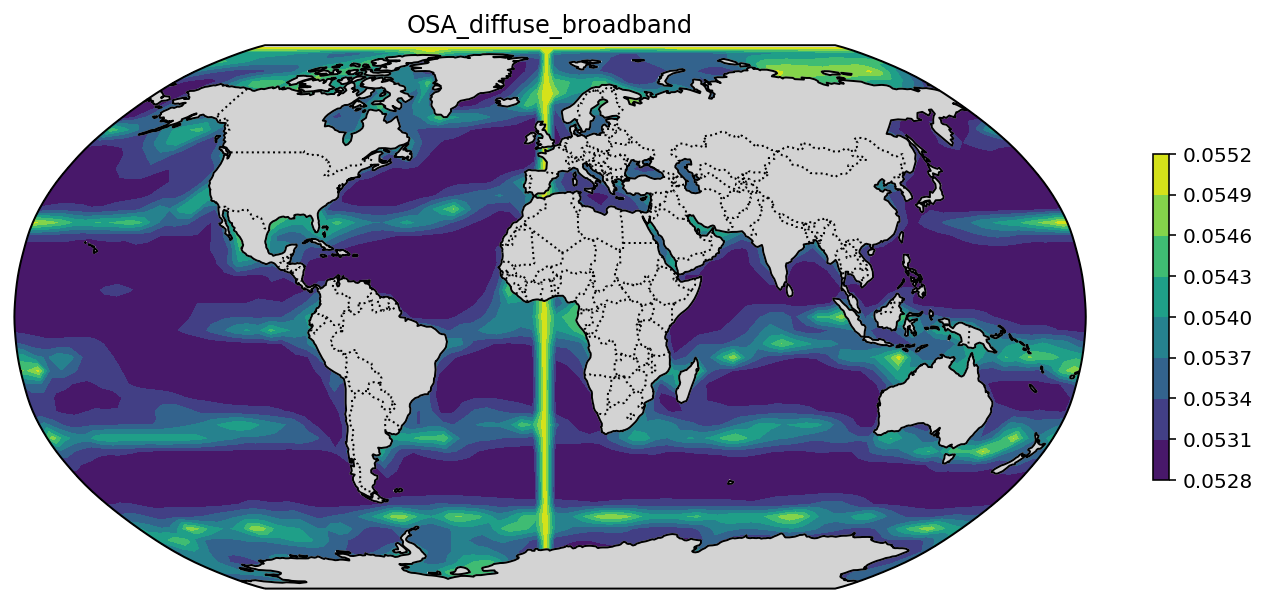

[[ 6.14806511e-01  6.14806511e-01  6.14806511e-01 ...  6.14806511e-01
   6.14806511e-01  6.14806511e-01]
 [ 3.05225316e-02  3.04926016e-02  3.04623234e-02 ...  3.06295404e-02
   3.05955860e-02  3.05596387e-02]
 [-3.16641233e+02 -3.21786608e+02 -3.22825788e+02 ... -2.68736999e+02
  -2.89017247e+02 -3.07836261e+02]
 ...
 [ 2.59640808e-02  2.59861324e-02  2.60247076e-02 ...  2.59443635e-02
   2.59508231e-02  2.59557185e-02]
 [-2.51774657e+00 -2.48743868e+00 -2.46813012e+00 ... -2.61174311e+00
  -2.59637047e+00 -2.56023395e+00]
 [-5.15834818e+00 -5.15834818e+00 -5.15834818e+00 ... -5.15834818e+00
  -5.15834818e+00 -5.15834818e+00]]
Time to finish 0:01:42.421794 with mean OSA nan
[[-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 ...
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]
 [-178. -174. -170. ...  174.  178.  182.]]


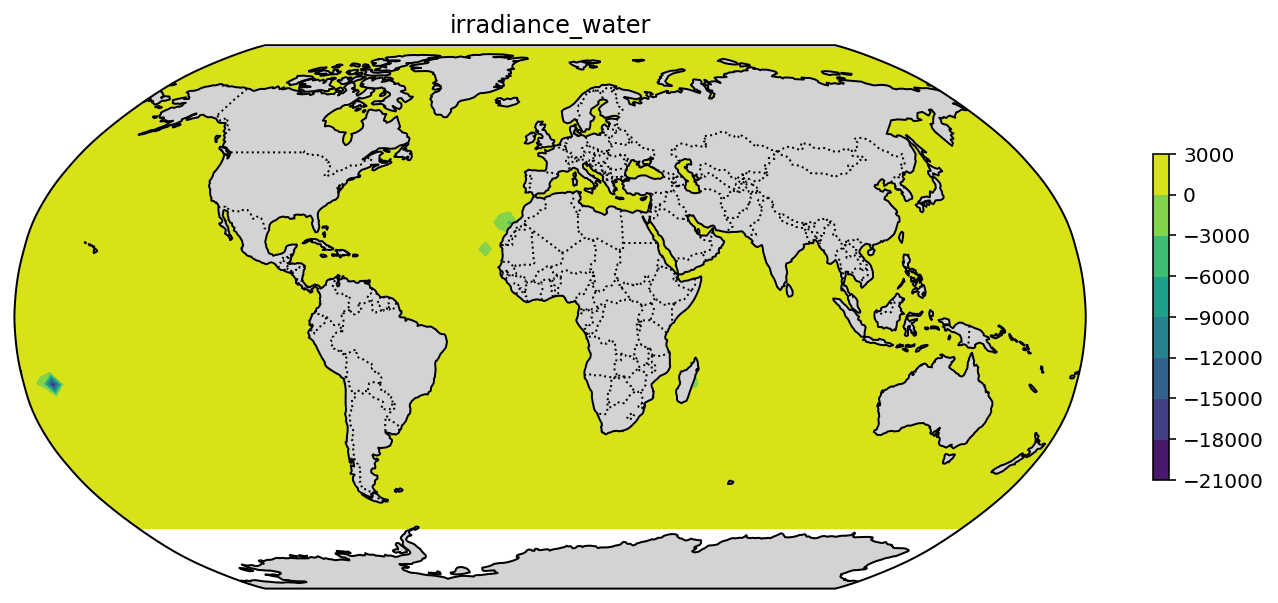

In [31]:
def calculate_light(config_pices_obj):
      
    selected_time=0
    show_plot=False
    wavelengths, refractive_indexes, alpha_chl, alpha_w, beta_w, alpha_wc, solar_energy = albedo.setup_parameters()
    startdate=datetime.datetime.now()
    
    for key in config_pices_obj.dset_dict.keys():
        
        var_name = key.split("_")[0]
        model_name = key.split("_")[3]
        
        if var_name=="uas":
            
            key_v="vas"+key[3:]
            key_tos="tos"+key[3:]
            key_clt="clt"+key[3:]
            
            var_name_v = key_v.split("_")[0]
            model_name_v = key_v.split("_")[3]
            
            print("=> model: {} variable name: {}".format(key, var_name))
            print("=> model: {} variable name: {}".format(key_v, var_name_v))
          
            if model_name_v==model_name:
                ds_uas=config_pices_obj.dset_dict[key].isel(time=selected_time)
                ds_vas=config_pices_obj.dset_dict[key_v].isel(time=selected_time)
                ds_tos=config_pices_obj.dset_dict[key_tos].isel(time=selected_time)
                ds_clt=config_pices_obj.dset_dict[key_clt].isel(time=selected_time)
                #ds_uas=ds_uas.sel(y=slice(0,90))
                #ds_vas=ds_vas.sel(y=slice(0,90))
            
                # Regrid to cartesian grid
                ds_out = xe.util.grid_global(4, 4)
                dr_out_uas=regrid_cmip6.regrid_variable("uas",ds_uas,ds_out,transpose=True)
                dr_out_vas=regrid_cmip6.regrid_variable("vas",ds_vas,ds_out,transpose=True)
                dr_out_tos=regrid_cmip6.regrid_variable("tos",ds_tos,ds_out,transpose=False)
                dr_out_clt=regrid_cmip6.regrid_variable("clt",ds_clt,ds_out,transpose=True)
                
                wind=np.sqrt(dr_out_uas**2+dr_out_vas**2).values
                
                lat=dr_out_uas.lat.values
                lon=dr_out_uas.lon.values
                
                create_plot(wind,lon,lat,"wind")
                
                clt=dr_out_clt.values
                create_plot(clt,lon,lat,"clouds")
                
                m=len(wind[:,0])
                n=len(wind[0,:])
                month=6
                
                all_direct=[]
                all_OSA=[]
                for hour_of_day in range(11,12,1):
                    print("Running for hour {}".format(hour_of_day))
                 
                    calc_radiation = [dask.delayed(radiation)(clt[j,:],lat[j,0],month,hour_of_day) for j in range(m)]
                   
                    # https://github.com/dask/dask/issues/5464   
                    rad = dask.compute(calc_radiation, scheduler='processes')
                    rads=np.asarray(rad).reshape((m, n, 3))
                  
                    create_plot(rads[:,:,0],lon,lat,"Direct radiation")
                    create_plot(rads[:,:,1],lon,lat,"Diffuse radiation")
                    create_plot(rads[:,:,2],lon,lat,"Apparent zenith")
                    
                    
                    chl=1.2
                    # Calculate broadband direct and diffuse albedo over water
                    # OSA[0] = direct
                    # OSA[1] = diffuse
                    zr = [dask.delayed(calculate_OSA)(np.cos(rads[i,j,2]), wind[i,j], chl, wavelengths, refractive_indexes, 
                                                    alpha_chl, alpha_w, beta_w, alpha_wc, solar_energy) 
                                  for i in range(m) 
                                  for j in range(n)]

                    OSA = np.asarray(dask.compute(zr)).reshape((m, n, 2))
                  
                    create_plot(OSA[:,:,0],lon,lat,"OSA_direct_broadband")
                    create_plot(OSA[:,:,1],lon,lat,"OSA_diffuse_broadband")
                    print(OSA[:,:,0])
                    irradiance_water = (rads[:,:,0]*OSA[:,:,0]+rads[:,:,1]*OSA[:,:,1])/(OSA[:,:,0]+OSA[:,:,1])
                    
                    print("Time to finish {} with mean OSA {}".format(datetime.datetime.now()-startdate,
                          np.mean(irradiance_water)))
                    
                    create_plot(irradiance_water,lon,lat,"irradiance_water")
            

              
calculate_light(config_pices_obj)

In [17]:
client.close()